# ArcFace Training on sample LFW Dataset

In [1]:
# Library imports
import os
import sys
sys.path.append(os.getcwd()[:-8])

import time
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from sklearn import metrics
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, utils

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import config
from data import *
from model_dynamics.metrics import ArcMarginProduct, AddMarginProduct, SphereProduct

# define root path 
ROOT_PATH = os.path.abspath(os.getcwd())[:-12]

In [21]:
# map the class names to labels
CLASS_DICT = {}
for i, class_ in enumerate(os.listdir(os.path.join(ROOT_PATH, "arcFace_dataset"))):
    CLASS_DICT[class_] = i   
print("Class Names -> Labels:\n", CLASS_DICT)


# conversely map the labels to class names
CLASS_NAMES = {v: k for k, v in CLASS_DICT.items()} 
print("\n\nClass Labels -> Names:\n", CLASS_NAMES)

Class Names -> Labels:
 {'Patty_Schnyder': 0, 'Paul_Bremer': 1, 'Paul_Burrell': 2, 'Paul_Martin': 3, 'Paul_McCartney': 4, 'Paul_ONeill': 5, 'Paul_Wolfowitz': 6, 'Pedro_Almodovar': 7, 'Pervez_Musharraf': 8, 'Peter_Struck': 9, 'Pete_Sampras': 10, 'Pierce_Brosnan': 11, 'Queen_Elizabeth_II': 12, 'Rachel_Hunter': 13, 'Ralf_Schumacher': 14, 'Ralph_Lauren': 15, 'Raquel_Welch': 16, 'Ray_Nagin': 17}


Class Labels -> Names:
 {0: 'Patty_Schnyder', 1: 'Paul_Bremer', 2: 'Paul_Burrell', 3: 'Paul_Martin', 4: 'Paul_McCartney', 5: 'Paul_ONeill', 6: 'Paul_Wolfowitz', 7: 'Pedro_Almodovar', 8: 'Pervez_Musharraf', 9: 'Peter_Struck', 10: 'Pete_Sampras', 11: 'Pierce_Brosnan', 12: 'Queen_Elizabeth_II', 13: 'Rachel_Hunter', 14: 'Ralf_Schumacher', 15: 'Ralph_Lauren', 16: 'Raquel_Welch', 17: 'Ray_Nagin'}


## Looking into the dataset for visualizing distinct classes 

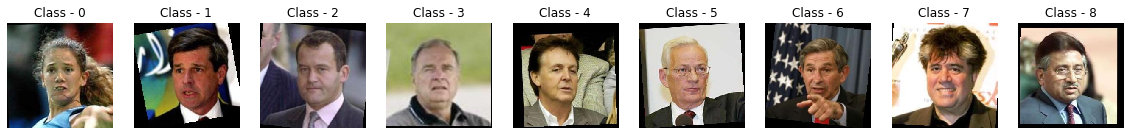

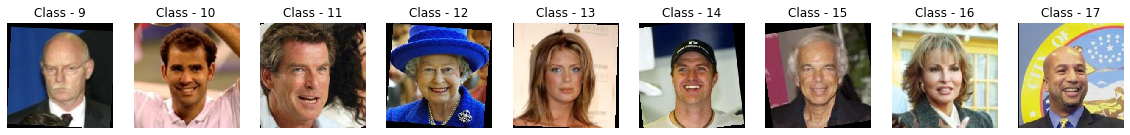

In [22]:
def plot_distinct_classes():
    """
    Collects the first image path from each class folder and plots it.
    """
    images = []
    for dir in os.listdir(os.path.join(ROOT_PATH, "arcFace_dataset")):
        image_name = os.listdir(os.path.join(ROOT_PATH, "arcFace_dataset", dir))[0]
        img = Image.open(os.path.join(ROOT_PATH, "arcFace_dataset", dir, image_name))
        images.append(img)

    fig1 = plt.figure(figsize=(20, 15))

    set1_figures = images[:9]
    index = 191
    for i, img in enumerate(set1_figures):
        plt.subplot(index+i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Class - {i}')  

    plt.show()

    fig2 = plt.figure(figsize=(20, 15))

    set2_figures = images[9:]
    index = 191
    for i, img in enumerate(set2_figures):
        plt.subplot(index+i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Class - {i+9}')    

    plt.show()

plot_distinct_classes()

In [3]:
def get_accuracy(output, target):
    predictions = torch.argmax(output.data, 1)
    accuracy = (predictions == target).sum().item() / target.size(0)
    return accuracy


def execute_trainstep(model, device, loader, loss_criterion, arc_distance, optimizer):
    model.train()
    arc_distance.train()
    losses = []
    accuracies = []
    f1_scores = []
    for idx, (image, target) in enumerate(loader):
        
        image, target = image.to(device), target.to(device).long()
        
        optimizer.zero_grad()
        
        feature = model(image)

        out = arc_distance(feature, target)

        loss = loss_criterion(out, target)
        losses.append(loss.item())
        
        accuracy = get_accuracy(out, target)
        accuracies.append(accuracy)

        f1_score = metrics.f1_score(target.cpu().numpy(), torch.argmax(out.data, 1).cpu().numpy(), average='macro')
        f1_scores.append(f1_score)
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses), np.mean(accuracies), np.mean(f1_scores)

def train(epochs, model, device, train_loader, loss_criterion, arc_distance, optimizer, scheduler):
    train_losses = []
    
    train_accuracies = []
    valid_accuracies = []

    train_f1_scores = []

    for epoch in range(1, epochs+1):
        
        start = time.time()
        
        train_loss, train_accuracy, train_f1_score = execute_trainstep(model, device, train_loader, loss_criterion, arc_distance, optimizer)
        valid_accuracy = validate_data(model, batch_size=16)
        
        #scheduler.step()

        end = time.time()
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1_score)
        valid_accuracies.append(valid_accuracy)

        print(f"""\nEpoch {epoch}/{epochs} Time : {end-start:.2f}s 
                Training Loss : {train_losses[-1]:.6f}
                Training Accuracy : {train_accuracies[-1]*100:.2f}% 
                Training F1 Score : {train_f1_scores[-1]*100:.2f}%
                Validation Accuracy : {valid_accuracies[-1]*100:.2f}%""")
        
    return train_losses, train_accuracies, train_f1_scores, valid_accuracies

In [4]:
def get_features(model, image_paths, batch_size=10):
    images = []
    features = None

    transformer = transforms.Compose([
                    transforms.Resize((128, 128)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()                    
                    ])

    for idx, imgPath in enumerate(image_paths):
        
        image = transformer(Image.open(imgPath))
        images.append(np.array(image))
       
        if ((len(images) % batch_size) == 0) or (idx == len(image_paths)-1):
            data = torch.from_numpy(np.asarray(images))            
            data = data.to(config.DEVICE)
            output = model(data)
            output = output.data.cpu().numpy()

            feature = output
            if features is None:
                features = feature
            else:
                features = np.vstack((features, feature))
            
            images = []
    return features


def cosine_metric(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))


def cal_accuracy(y_score, y_true):
    y_score = np.asarray(y_score)
    y_true = np.asarray(y_true)
    best_acc = 0
    best_th = 0
    for i in range(len(y_score)):
        th = y_score[i]
        y_test = (y_score >= th)
        acc = np.mean((y_test == y_true).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_th = th

    return (best_acc, best_th)


def test_performance(fe_dict, targets):
    with open(os.path.join(ROOT_PATH, "src", "test_pair.txt"), 'r') as fd:
        pairs = fd.readlines()            
    sims = []
    labels = []
    for pair in pairs:
        splits = pair.split()
        s1 = splits[0]
        s2 = splits[1]
        s3 = splits[2]
        if (s1 in targets) and (s2 in targets):
            fe_1 = fe_dict[s1]
            fe_2 = fe_dict[s2]
            label = int(s3)
            sim = cosine_metric(fe_1, fe_2)

            sims.append(sim)
            labels.append(label)
    acc, th = cal_accuracy(sims, labels)
    return acc, th


def test_data_list():
    with open(os.path.join(ROOT_PATH, "src", "test_pair.txt"), 'r') as fd:
        pairs = fd.readlines()
    data_list = []
    for pair in pairs:
        splits = pair.split()

        if splits[0] not in data_list:
            data_list.append(splits[0])

        if splits[1] not in data_list:
            data_list.append(splits[1])
    return data_list


def get_feature_dict(targets, features):
    dict_ = {}
    for i, t in enumerate(targets):
        dict_[t] = features[i]
    return dict_ 


def validate_data(model, batch_size=10):
    s = time.time()
    model.eval()
    targets = test_data_list()
    if (len(targets)%2) != 0:
        targets = targets[:-1]
    img_paths = [os.path.join(ROOT_PATH, "arcFace_dataset", id) for id in targets]
    features = get_features(model, img_paths, batch_size=batch_size)    
    feature_dict = get_feature_dict(targets, features) 
    acc, th = test_performance(feature_dict, targets)
    print('lfw face verification accuracy: ', acc, 'threshold: ', th)
    return acc

In [5]:
normalize = transforms.Normalize(mean=[0.5], std=[0.5])
transformer = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                            ])

train_test_images_dict = get_train_test_images_data_dict(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset")
)

generate_pair_file_for_test_images(
    dataDict=train_test_images_dict,
    root_path=ROOT_PATH,
    class_dict=CLASS_DICT
)

train_dataset = ArcFaceDataset(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_test_images_dict,
    train=True,
    transform=transformer
)

test_dataset = ArcFaceDataset(
    data_path=os.path.join(ROOT_PATH, "arcFace_dataset"),
    class_dict=CLASS_DICT,
    train_test_image_data_dict=train_test_images_dict,
    train=False,
    transform=transformer
)

batch_size = 16
train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size= batch_size)

In [6]:
device = config.DEVICE

print(device)

torch.cuda.empty_cache()

criterion = nn.CrossEntropyLoss()

from torchvision.models.resnet import resnet18

model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 512)
model.to(device)

metric_fc = ArcMarginProduct(512, 18, s=30, m=0.5,easy_margin=False) 
metric_fc.to(device)


optimizer = torch.optim.SGD([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                    lr=1e-2, weight_decay=5e-4)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)                                

cuda


In [7]:
n_epochs = 100
train_losses, train_accuracies, train_f1_scores, valid_accuracies = train(n_epochs, model, device, 
                                                                       train_loader, criterion, metric_fc, optimizer, scheduler)

lfw face verification accuracy:  0.7818181818181819 threshold:  0.6436227

Epoch 1/100 Time : 1.85s 
                Training Loss : 17.826391
                Training Accuracy : 0.00% 
                Training F1 Score : 0.00%
                Validation Accuracy : 78.18%
lfw face verification accuracy:  0.6363636363636364 threshold:  0.5679368

Epoch 2/100 Time : 0.70s 
                Training Loss : 14.787392
                Training Accuracy : 0.00% 
                Training F1 Score : 0.00%
                Validation Accuracy : 63.64%
lfw face verification accuracy:  0.8 threshold:  0.45691547

Epoch 3/100 Time : 0.70s 
                Training Loss : 10.593802
                Training Accuracy : 5.73% 
                Training F1 Score : 3.55%
                Validation Accuracy : 80.00%
lfw face verification accuracy:  0.8545454545454545 threshold:  0.2972914

Epoch 4/100 Time : 0.71s 
                Training Loss : 6.458773
                Training Accuracy : 28.91% 
         

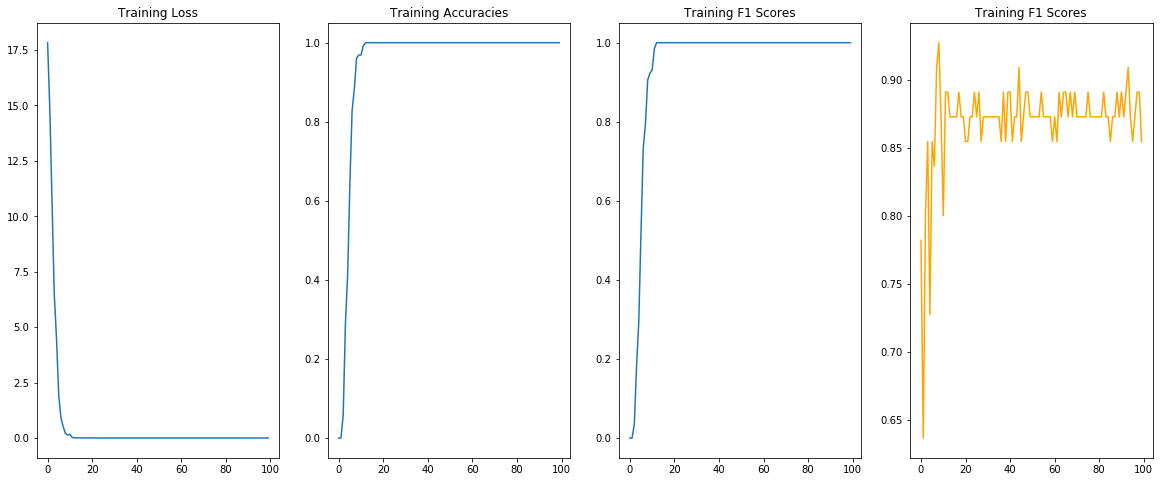

In [11]:
# loss
fig1 = plt.figure(figsize=(20, 8))
plt.subplot(141)
plt.plot(train_losses)
plt.title("Training Loss")

plt.subplot(142)
plt.plot(train_accuracies)
plt.title("Training Accuracies")

plt.subplot(143)
plt.plot(train_f1_scores)
plt.title("Training F1 Scores")

plt.subplot(144)
plt.plot(valid_accuracies, color="orange")
plt.title("Validation Accuracy")

plt.show()

In [12]:
# Save the model parameters
torch.save(model.state_dict(), os.path.join(ROOT_PATH, 'models', './arcFace_ep'+str(100)+'.pt'))
torch.save(metric_fc.state_dict(), os.path.join(ROOT_PATH, 'models', './arcFace_metricFc'+str(100)+'.pt'))